# SIDO-low-pass-filter
Last update: 12 Feb 2024  

![SIDO low pass filter](SIDO-low-pass-filter.png){#fig-SIDO-low-pass-filter}  

## Introduction

[electronics stackexchange](https://electronics.stackexchange.com/)

@fig-SIDO-low-pass-filter

@user349644

## Circuit description


## Circuit analysis
 
- find the transfer function


The net list for the filter is:
```
* C:\users\jeff64\My Documents\SIDO-low-pass-filter\SIDO-low-pass-filter.asc
V1 1 0 1
C1 1 0 2.2n
C2 4 5 330p
C3 2 3 100p
R1 1 0 100k
R2 4 1 4.7k
R3 5 0 4.7k
R4 2 4 10k
R5 3 5 10k
.op
.backanno
.end

```

The following Python modules are used.

In [26]:
from sympy import *
import numpy as np
from tabulate import tabulate
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()

In [27]:
t = symbols('t',positive=True)  # t > 0

### Load the netlist
The netlist generated by LTSpice is pasted into the cell below and some edits were made to remove the inductor series resistance and the independent sources are set to their DC values.

In [28]:
net_list = '''
V1 1 0 1
C1 1 0 2.2e-9
C2 4 5 330e-12
C3 2 3 100e-12
R1 1 0 100e3
R2 4 1 4.7e3
R3 5 0 4.7e3
R4 2 4 10e3
R5 3 5 10e3
'''

Generate the network equations.

In [29]:
report, network_df, df2, A, X, Z = SymMNA.smna(net_list)

# Put matricies into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

Generate markdown text to display the network equations.

In [30]:
temp = ''
for i in range(len(X)):
    temp += '${:s}$<br>'.format(latex(Eq((A*X)[i:i+1][0],Z[i])))

Markdown(temp)

$I_{V1} + v_{1} \left(C_{1} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{4}}{R_{2}} = 0$<br>$- C_{3} s v_{3} + v_{2} \left(C_{3} s + \frac{1}{R_{4}}\right) - \frac{v_{4}}{R_{4}} = 0$<br>$- C_{3} s v_{2} + v_{3} \left(C_{3} s + \frac{1}{R_{5}}\right) - \frac{v_{5}}{R_{5}} = 0$<br>$- C_{2} s v_{5} + v_{4} \left(C_{2} s + \frac{1}{R_{4}} + \frac{1}{R_{2}}\right) - \frac{v_{2}}{R_{4}} - \frac{v_{1}}{R_{2}} = 0$<br>$- C_{2} s v_{4} + v_{5} \left(C_{2} s + \frac{1}{R_{5}} + \frac{1}{R_{3}}\right) - \frac{v_{3}}{R_{5}} = 0$<br>$v_{1} = V_{1}$<br>

As shown above MNA generated many equations and these would be difficult to solve by hand and a symbolic soultion would take a lot of computing time. The equations are displace in matrix notation.

In [31]:
NE_sym

⎡              ⎛       1    1 ⎞   v₄     ⎤       
⎢    I_V1 + v₁⋅⎜C₁⋅s + ── + ──⎟ - ──     ⎥       
⎢              ⎝       R₂   R₁⎠   R₂     ⎥       
⎢                                        ⎥       
⎢                   ⎛       1 ⎞   v₄     ⎥       
⎢     -C₃⋅s⋅v₃ + v₂⋅⎜C₃⋅s + ──⎟ - ──     ⎥   ⎡0 ⎤
⎢                   ⎝       R₄⎠   R₄     ⎥   ⎢  ⎥
⎢                                        ⎥   ⎢0 ⎥
⎢                   ⎛       1 ⎞   v₅     ⎥   ⎢  ⎥
⎢     -C₃⋅s⋅v₂ + v₃⋅⎜C₃⋅s + ──⎟ - ──     ⎥   ⎢0 ⎥
⎢                   ⎝       R₅⎠   R₅     ⎥ = ⎢  ⎥
⎢                                        ⎥   ⎢0 ⎥
⎢              ⎛       1    1 ⎞   v₂   v₁⎥   ⎢  ⎥
⎢-C₂⋅s⋅v₅ + v₄⋅⎜C₂⋅s + ── + ──⎟ - ── - ──⎥   ⎢0 ⎥
⎢              ⎝       R₄   R₂⎠   R₄   R₂⎥   ⎢  ⎥
⎢                                        ⎥   ⎣V₁⎦
⎢                ⎛       1    1 ⎞   v₃   ⎥       
⎢  -C₂⋅s⋅v₄ + v₅⋅⎜C₂⋅s + ── + ──⎟ - ──   ⎥       
⎢                ⎝       R₅   R₃⎠   R₅   ⎥       
⎢                                        ⎥       


The symbols generated by the Python code are extraced by the SymPy function free_symbols and then declared as SymPy variables. 

In [32]:
# turn the free symbols into SymPy variables
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

Built a dictionary of element values.

In [33]:
element_values = SymMNA.get_part_values(network_df)
element_values

Generate the symbolic solution

In [34]:
U_sym = solve(NE_sym,X)

Display the symbolic solution

In [35]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} + C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} + C_{2} R_{3} V_{1} s + C_{3} R_{3} V_{1} s + C_{3} R_{5} V_{1} s + V_{1}}{C_{2} C_{3} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{3} R_{5} s^{2} + C_{2} R_{2} s + C_{2} R_{3} s + C_{3} R_{2} s + C_{3} R_{3} s + C_{3} R_{4} s + C_{3} R_{5} s + 1}$<br>$v_{3} = \frac{C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} + C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} + C_{2} R_{3} V_{1} s + C_{3} R_{3} V_{1} s + C_{3} R_{5} V_{1} s}{C_{2} C_{3} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{3} R_{5} s^{2} + C_{2} R_{2} s + C_{2} R_{3} s + C_{3} R_{2} s + C_{3} R_{3} s + C_{3} R_{4} s + C_{3} R_{5} s + 1}$<br>$v_{4} = \frac{C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} + C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} + C_{2} R_{3} V_{1} s + C_{3} R_{3} V_{1} s + C_{3} R_{4} V_{1} s + C_{3} R_{5} V_{1} s + V_{1}}{C_{2} C_{3} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{3} R_{5} s^{2} + C_{2} R_{2} s + C_{2} R_{3} s + C_{3} R_{2} s + C_{3} R_{3} s + C_{3} R_{4} s + C_{3} R_{5} s + 1}$<br>$v_{5} = \frac{C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} + C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} + C_{2} R_{3} V_{1} s + C_{3} R_{3} V_{1} s}{C_{2} C_{3} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{3} R_{5} s^{2} + C_{2} R_{2} s + C_{2} R_{3} s + C_{3} R_{2} s + C_{3} R_{3} s + C_{3} R_{4} s + C_{3} R_{5} s + 1}$<br>$I_{V1} = \frac{- C_{1} C_{2} C_{3} R_{1} R_{2} R_{4} V_{1} s^{3} - C_{1} C_{2} C_{3} R_{1} R_{2} R_{5} V_{1} s^{3} - C_{1} C_{2} C_{3} R_{1} R_{3} R_{4} V_{1} s^{3} - C_{1} C_{2} C_{3} R_{1} R_{3} R_{5} V_{1} s^{3} - C_{1} C_{2} R_{1} R_{2} V_{1} s^{2} - C_{1} C_{2} R_{1} R_{3} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{2} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{3} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{4} V_{1} s^{2} - C_{1} C_{3} R_{1} R_{5} V_{1} s^{2} - C_{1} R_{1} V_{1} s - C_{2} C_{3} R_{1} R_{4} V_{1} s^{2} - C_{2} C_{3} R_{1} R_{5} V_{1} s^{2} - C_{2} C_{3} R_{2} R_{4} V_{1} s^{2} - C_{2} C_{3} R_{2} R_{5} V_{1} s^{2} - C_{2} C_{3} R_{3} R_{4} V_{1} s^{2} - C_{2} C_{3} R_{3} R_{5} V_{1} s^{2} - C_{2} R_{1} V_{1} s - C_{2} R_{2} V_{1} s - C_{2} R_{3} V_{1} s - C_{3} R_{1} V_{1} s - C_{3} R_{2} V_{1} s - C_{3} R_{3} V_{1} s - C_{3} R_{4} V_{1} s - C_{3} R_{5} V_{1} s - V_{1}}{C_{2} C_{3} R_{1} R_{2} R_{4} s^{2} + C_{2} C_{3} R_{1} R_{2} R_{5} s^{2} + C_{2} C_{3} R_{1} R_{3} R_{4} s^{2} + C_{2} C_{3} R_{1} R_{3} R_{5} s^{2} + C_{2} R_{1} R_{2} s + C_{2} R_{1} R_{3} s + C_{3} R_{1} R_{2} s + C_{3} R_{1} R_{3} s + C_{3} R_{1} R_{4} s + C_{3} R_{1} R_{5} s + R_{1}}$<br>

In [36]:
U_sym[v1]

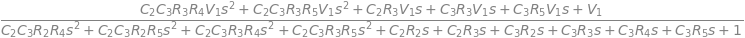

In [37]:
U_sym[v2]

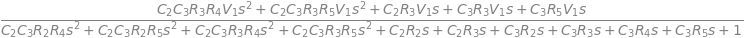

In [38]:
U_sym[v3]

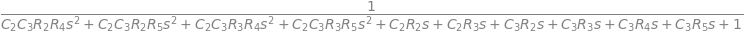

In [39]:
((U_sym[v2]-U_sym[v3])/U_sym[v1]).simplify()

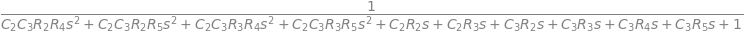

In [40]:
((U_sym[v2]-U_sym[v3])/U_sym[v1]).nsimplify().simplify().expand().together()

In [41]:
NE = NE_sym.subs(element_values)
NE

⎡           I_V1 + v₁⋅(2.2e-9⋅s + 0.000222765957446809) - 0.000212765957446809
⎢                                                                             
⎢                    -1.0e-10⋅s⋅v₃ + v₂⋅(1.0e-10⋅s + 0.0001) - 0.0001⋅v₄      
⎢                                                                             
⎢                    -1.0e-10⋅s⋅v₂ + v₃⋅(1.0e-10⋅s + 0.0001) - 0.0001⋅v₅      
⎢                                                                             
⎢-3.3e-10⋅s⋅v₅ - 0.000212765957446809⋅v₁ - 0.0001⋅v₂ + v₄⋅(3.3e-10⋅s + 0.00031
⎢                                                                             
⎢             -3.3e-10⋅s⋅v₄ - 0.0001⋅v₃ + v₅⋅(3.3e-10⋅s + 0.000312765957446809
⎢                                                                             
⎣                                            v₁                               

⋅v₄           ⎤   ⎡ 0 ⎤
              ⎥   ⎢   ⎥
              ⎥   ⎢ 0 ⎥
              ⎥   ⎢   ⎥
              ⎥   ⎢ 0 ⎥
          

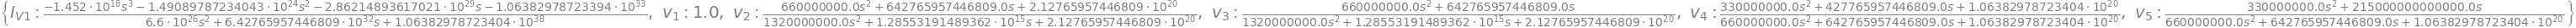

In [42]:
U = solve(NE,X)
U

In [43]:
temp = ''
for i in U.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U[i]))

Markdown(temp)

$v_{1} = 1.0$<br>$v_{2} = \frac{660000000.0 s^{2} + 642765957446809.0 s + 2.12765957446809 \cdot 10^{20}}{1320000000.0 s^{2} + 1.28553191489362 \cdot 10^{15} s + 2.12765957446809 \cdot 10^{20}}$<br>$v_{3} = \frac{660000000.0 s^{2} + 642765957446809.0 s}{1320000000.0 s^{2} + 1.28553191489362 \cdot 10^{15} s + 2.12765957446809 \cdot 10^{20}}$<br>$v_{4} = \frac{330000000.0 s^{2} + 427765957446809.0 s + 1.06382978723404 \cdot 10^{20}}{660000000.0 s^{2} + 642765957446809.0 s + 1.06382978723404 \cdot 10^{20}}$<br>$v_{5} = \frac{330000000.0 s^{2} + 215000000000000.0 s}{660000000.0 s^{2} + 642765957446809.0 s + 1.06382978723404 \cdot 10^{20}}$<br>$I_{V1} = \frac{- 1.452 \cdot 10^{18} s^{3} - 1.49089787234043 \cdot 10^{24} s^{2} - 2.86214893617021 \cdot 10^{29} s - 1.06382978723394 \cdot 10^{33}}{6.6 \cdot 10^{26} s^{2} + 6.42765957446809 \cdot 10^{32} s + 1.06382978723404 \cdot 10^{38}}$<br>

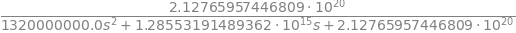

In [44]:
((U[v2]-U[v3])/U[v1]).simplify()

In [45]:
((U[v2]-U[v3])/U[v1]).nsimplify().simplify().expand().together()

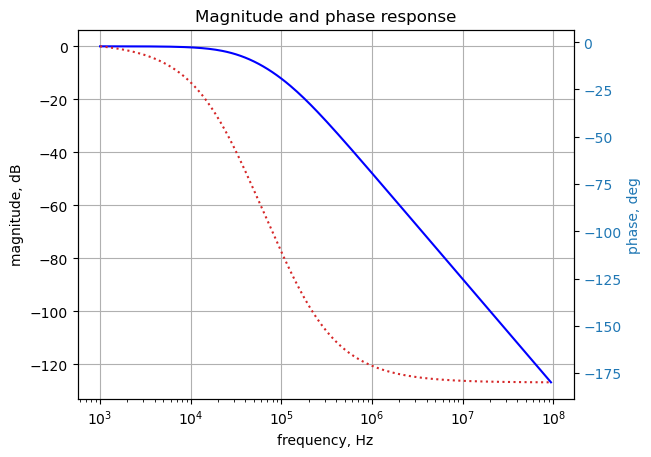

In [47]:
H = ((U[v2]-U[v3])/U[v1]).nsimplify().simplify().expand().together()

num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)
system = (a, b)

x = np.logspace(3, 8, 200, endpoint=False)*2*np.pi
w, mag, phase = signal.bode(system, w=x) # returns: rad/s, mag in dB, phase in deg

fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y')
#ax1.set_ylim((-30,20))
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim((-5,25))

plt.title('Magnitude and phase response')
plt.show()